# Analysis of Fashion data

## Overview
**Goal:** Use an ANN model from the previous notebook to optimize predictions and create a recommender system to provide outfit recommendations based on product popularity.

### Load our data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# data preprocessing and tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize, OneHotEncoder
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

# Suite of Machine Learning Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# recommendation system
import multiprocessing as mp
from multiprocessing import Pool
from functools import partial

import helper

# to get the newest version of helper
import importlib
importlib.reload(helper)

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

2024-12-11 14:36:29.893832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load the model data from previous notebook
modeldata_df = pd.read_csv("../data/modeldata_df.csv")
modeldata_df.head()

,product_code,product_type_no,product_group_name,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,popularity
0,108775,253,Garment Upper body,1010016,9,4,5,1676,A,1,16,1002,low
1,108775,253,Garment Upper body,1010016,10,3,9,1676,A,1,16,1002,high
2,108775,253,Garment Upper body,1010017,11,1,9,1676,A,1,16,1002,low
3,110065,306,Underwear,1010016,9,4,5,1339,B,1,61,1017,medium
4,110065,306,Underwear,1010016,10,3,9,1339,B,1,61,1017,medium


In [3]:
# load the transaction data from previous notebook
transactions_df = pd.read_csv("../data/newest_trans_df.csv")
transactions_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,743123001,0.011847,2
1,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,743123001,0.011847,2
2,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,849597003,0.012186,2
3,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,599580052,0.016932,2
4,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,599580052,0.016932,2


In [4]:
# load the article data from previous notebook
articles_df = pd.read_csv("../data/articles_df.csv")
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [6]:
# load the customer data from previous notebook
customers_df = pd.read_csv("../data/customer_df.csv")
customers_df.head()

,customer_id,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [7]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035461 entries, 0 to 2035460
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 77.6+ MB


## Feature Selection & Engineering

In [8]:
# create a merged dataset with all the transaction, article, and customer data
merged_df = transactions_df.merge(customers_df, on="customer_id", how="left")
merged_df = merged_df.merge(articles_df, on="article_id", how="left")

merged_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,age,postal_code,product_code,prod_name,product_type_no,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,743123001,0.011847,2,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,743123,Frenchy Padded Bra,298,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,"Bikini top with underwired, moulded, lightly p..."
1,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,743123001,0.011847,2,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,743123,Frenchy Padded Bra,298,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,"Bikini top with underwired, moulded, lightly p..."
2,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,849597003,0.012186,2,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,849597,Nissan Dress,265,...,Woven Tops,A,Ladieswear,1,Ladieswear,8,Mama,1010,Blouses,"Short, sleeveless dress in airy chiffon with a..."
3,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,599580052,0.016932,2,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,599580,Timeless Midrise Brief,59,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,Fully lined bikini bottoms with a mid waist an...
4,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,599580052,0.016932,2,40.0,0c0e15f8fa88a1d4aa6ca8a0b4a8289ca1affbaebdea22...,599580,Timeless Midrise Brief,59,...,Swimwear,B,Lingeries/Tights,1,Ladieswear,60,"Womens Swimwear, beachwear",1018,Swimwear,Fully lined bikini bottoms with a mid waist an...


In [10]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035461 entries, 0 to 2035460
Data columns (total 31 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   t_dat                         object 
 1   customer_id                   object 
 2   article_id                    int64  
 3   price                         float64
 4   sales_channel_id              int64  
 5   age                           float64
 6   postal_code                   object 
 7   product_code                  int64  
 8   prod_name                     object 
 9   product_type_no               int64  
 10  product_type_name             object 
 11  product_group_name            object 
 12  graphical_appearance_no       int64  
 13  graphical_appearance_name     object 
 14  colour_group_code             int64  
 15  colour_group_name             object 
 16  perceived_colour_value_id     int64  
 17  perceived_colour_value_name   object 
 18  perceived_colour_maste

### Defining our Index
Our popularity index will be the number of times an article of clothing was purchased in the last 2 months.

In [ ]:
# feature select
# save purchase_count of each article_id in articles_df
merged_df["purchase_count"] = merged_df["article_id"].map(merged_df["article_id"].value_counts())

merged_df["purchase_count"].isna().sum()


0

We want to use classification models to predict popularity, so we first need to create bins to classify articles of clothing as low, medium, or high popularity based on their purchase counts.

In [13]:
# Create buckets for popularity based on purchase counts
min_val = merged_df["purchase_count"].min()
q2 = merged_df["purchase_count"].quantile(0.25)
q3 = merged_df["purchase_count"].quantile(0.75)
# mean_val = merged_df["purchase_count"].mean()
max_val = merged_df["purchase_count"].max()

# we have to create arbitrary boundaries for the buckets since the
# purchase counts are all quite low except for some outliers
buckets = [min_val - 1, q2, q3, max_val + 1]
labels = ["low", "medium", "high"]

merged_df["popularity"] = pd.cut(merged_df["purchase_count"], bins=buckets, labels=labels)

merged_df["article_id"].count()

2035461

In [ ]:
"""
# Create buckets for popularity based on purchase counts
min_val = merged_df["purchase_count"].min()
mean_val = merged_df["purchase_count"].mean()
max_val = merged_df["purchase_count"].max()

# we have to create arbitrary boundaries for the buckets since the
# purchase counts are all quite low except for some outliers
buckets = [min_val - 1, 0, mean_val, max_val + 1]
labels = ["low", "medium", "high"]

articles_df["popularity"] = pd.cut(articles_df["purchase_count"], bins=buckets, labels=labels)

articles_df["article_id"].count()
"""

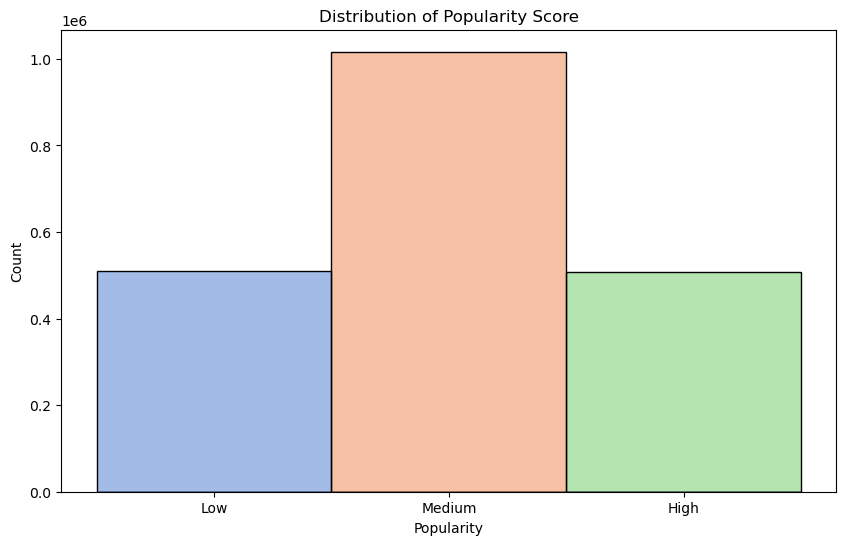

In [14]:
# Presentation Visual
# let's graph the distribution of the popularity score
plt.figure(figsize=(10, 6))

sns.histplot(merged_df, x="popularity", hue="popularity", legend=False, palette="muted")
plt.title("Distribution of Popularity Score")
plt.xlabel("Popularity")
plt.ylabel("Count")
plt.xticks([0, 1, 2], ["Low", "Medium", "High"])

plt.show()

In [ ]:
# feature engineering: create target: popularity index

In [ ]:
# Initial model: ANN Model
# with LeakyRelu and learning rate scheduler